# Scene Change Detector

### Описание входных данных

Выборка для тренировки лежит https://titan.gml-team.ru:5003/sharing/yX8enupJV

Данные о каждом видео лежат в файле *train_dataset\info.json*. Это список из словарей, каждый словарь содержит информацию о расположении видео, о расположении ответов на смены сцен и содержит длину видео

In [1]:
import numpy as np
import cv2 
from tqdm.notebook import tqdm 
from tqdm import notebook 
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [35]:
import json
def load_json_from_file(filename):
    with open(filename, "r") as f:
        return json.load(f, strict=False)


def dump_json_to_file(obj, filename, **kwargs):
    with open(filename, "w") as f:
        json.dump(obj, f, **kwargs)

In [36]:
video_dataset = load_json_from_file('train_dataset/info.json')
video_dataset

[{'source': 'video/03.mp4', 'scene_change': 'gt/03.json', 'len': 3250},
 {'source': 'video/04.mp4', 'scene_change': 'gt/04.json', 'len': 3392},
 {'source': 'video/05.mp4', 'scene_change': 'gt/05.json', 'len': 5662},
 {'source': 'video/07.mp4', 'scene_change': 'gt/07.json', 'len': 3321},
 {'source': 'video/08.mp4', 'scene_change': 'gt/08.json', 'len': 3396},
 {'source': 'video/10.mp4', 'scene_change': 'gt/10.json', 'len': 6096},
 {'source': 'video/14.mp4', 'scene_change': 'gt/14.json', 'len': 2326},
 {'source': 'video/17.mp4', 'scene_change': 'gt/17.json', 'len': 2904},
 {'source': 'video/21.mp4', 'scene_change': 'gt/21.json', 'len': 4898},
 {'source': 'video/22.mp4', 'scene_change': 'gt/22.json', 'len': 7749}]

### Загрузка видео ###

In [37]:
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==False:
            break
        yield frame
    cap.release()

In [38]:
frames = read_video(os.path.join('train_dataset', 'video', '30.mp4'))

### Базовый детектор смен сцен

Базовый метод считает межкадровую разницу между кадрами.

Здесь и далее результатом алгоритма детектора сцен являются **индексы кадров начал сцен**, при этом кадры **нумеруются с 0**

<img src="Hard_cut.jpg">

In [39]:
def baseline_scene_change_detector(frames, threshold=2000, with_vis=False):
    """
    Baseline SCD

    Arguments:
    frames -- iterator on video frames
    threshold -- parameter of your algorithm (optional)
    with_vis -- saving neighboring frames at a scene change (optional)

    Returns:
    scene_changes -- list of scene changes (idx of frames)
    vis -- list of neighboring frames at a scene change (for visualization)
    metric_values -- list of metric values (for visualization)
    """
    
    def pixel_metric(frame, prev_frame):
        # Базовое расстояние между кадрами - среднеквадратическая ошибка между ними
        return np.mean((frame.astype(np.int32) - prev_frame) ** 2)

    scene_changes = []
    vis = []
    metric_values = []
    prev_frame = None
    for idx, frame in notebook.tqdm(enumerate(frames), leave=False):
        # frame - это кадр
        # idx - это номер кадра
        if prev_frame is not None:
            # Находим расстояние между соседними кадрами
            metric_value = pixel_metric(frame, prev_frame)
            if metric_value > threshold:
                scene_changes.append(idx)
                if with_vis:
                    # Кадры в памяти занимают много места, поэтому сохраним лишь первые 100 срабатываний
                    if len(vis) < 100:
                        vis.append([prev_frame, frame])
            metric_values.append(metric_value)
        else:
            metric_values.append(0)
        prev_frame = frame
    return scene_changes, vis, metric_values

In [7]:
frames = read_video(os.path.join('train_dataset', 'video', '21.mp4'))
cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', '03.json'))['cut']
scene_changes_base, vis_base, metric_values_base = baseline_scene_change_detector(frames, 2000, with_vis=True)

Посмотрим визуально, насколько сильно алгоритм ошибается, а также на значения метрики

In [8]:
def visualize_metric_error(frame, prev_frame, value):
    fig = plt.figure(figsize=(16,4))
    plt.suptitle('Значение метрики на текущем кадре: {:.4f}'.format(value), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(prev_frame[:,:,::-1])
    ax.set_title("Предыдущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(frame[:,:,::-1])
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(top=0.80)

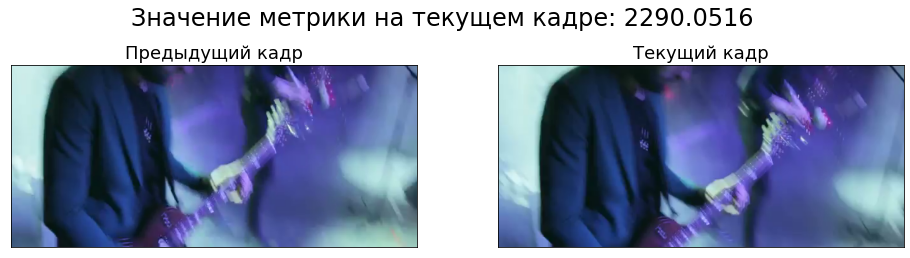

In [9]:
idx = 7
visualize_metric_error(vis_base[idx][0], vis_base[idx][1], metric_values_base[scene_changes_base[idx]])

In [10]:
def visualize_metric_values(metric_values, threshold, cuts = None):
    sns.set()
    plt.figure(figsize=(16, 8))
    plt.plot(metric_values, label='Значение метрики на кадрах')
    plt.xlabel('Номер кадра')
    plt.ylabel('Значение метрики')
    plt.hlines(y=threshold, xmin=0, xmax=len(metric_values), linewidth=2, color='r', label='Пороговое значение')
    
    if cuts is not None:
        for cut in cuts:
            plt.axvline(x=cut, color='k', linestyle=':', linewidth=0.5, label='Смена сцены')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

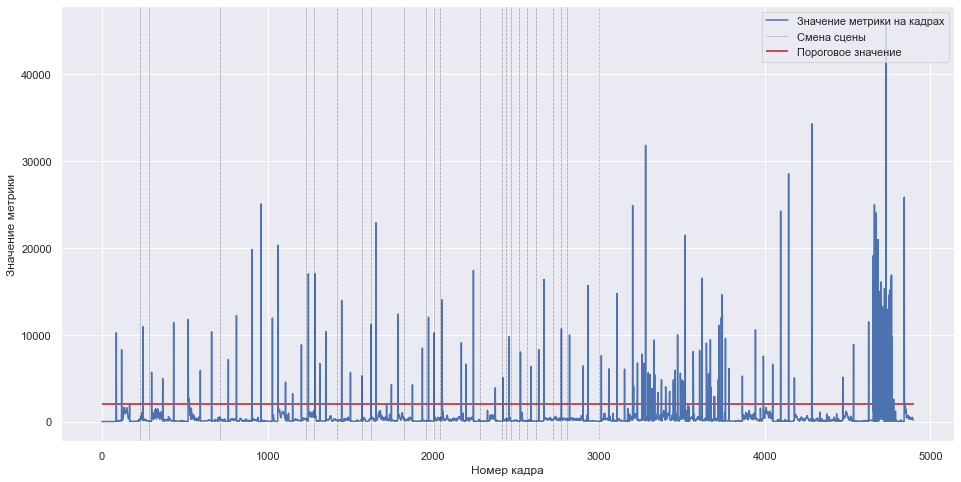

In [11]:
visualize_metric_values(metric_values_base, 2000, cuts_base)

### Улучшенное решение

In [12]:
def scene_change_detector(frames, threshold = 6, with_vis=False):
    """
    SCD

    Arguments:
    frames -- iterator on video frames
    threshold -- parameter of your algorithm (optional)
    with_vis -- saving neighboring frames at a scene change (optional)

    Returns:
    scene_changes -- list of scene changes (idx of frames)
    vis -- list of neighboring frames at a scene change (for visualization)
    metric_values -- list of metric values (for visualization)
    
    """

    # _v1 uses only one channel while _v2 uses all 3 channels in counting the difference of histograms
    def abs_metric_bins_v1(frame_1, frame_2, channels, colors):
        ar = np.abs(cv2.calcHist([frame_1],[channels],None,[colors],[0,256]) - cv2.calcHist([frame_2],[channels],None,[colors],[0,256]))
        
        return ar.reshape(colors)
    
    def chi_square_metric_bins_v1(frame_1, frame_2, channels, colors):
        temp = cv2.calcHist([frame_2],[channels],None,[colors],[0,256])
        temp[temp == 0] = 1
        ar = np.square(cv2.calcHist([frame_1],[channels],None,[colors],[0,256]) - temp)/temp
        return ar.reshape(colors)

    def abs_metric_bins_v2(frame_1, frame_2, channels, colors):
        hist_1 = cv2.calcHist([frame_1],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2 = cv2.calcHist([frame_2],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2[hist_2 == 0] = 1
        ar = np.abs(hist_1 - hist_2)
        
        return ar.reshape(colors)
    
    def chi_square_metric_bins_v2(frame_1, frame_2):
        hist_1 = cv2.calcHist([frame_1],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2 = cv2.calcHist([frame_2],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2[hist_2 == 0] = 1
        ar = np.square(hist_1 - hist_2) / hist_2
        return np.sum(ar) / 64
    
    def chi_square_metric_subregions_v1(frame_1, frame_2):
        shape_row = frame_1.shape[0] // 4
        shape_col = frame_1.shape[1] // 4
        sum_global = np.array([])
        for i in np.arange(4):
            for j in np.arange(4):
                ar = 0
                for channel in [0,1,2]:
                    region_1 = frame_1[i * shape_row : (i + 1) * shape_row, j * shape_col : (j + 1) * shape_col]
                   
                    region_2 = frame_2[i * shape_row : (i + 1) * shape_row, j * shape_col : (j + 1) * shape_col]
                    ar += np.sum(chi_square_metric_bins_v1(region_1, region_2, channel, 64)) / 64
                sum_temp = ar / 3
               
                sum_global = np.append(sum_global, sum_temp)
        sum_global = np.sort(sum_global)[0:8]
        
        return 1000 * np.sum(sum_global) / (shape_row * shape_col )
    # reducing the flash effect by using sobel operator
    def sobel(frame):
        ddept = cv2.CV_64F
        x = cv2.Sobel(frame, ddept, 1,0, ksize=3, scale=1)
        y = cv2.Sobel(frame, ddept, 0,1, ksize=3, scale=1)
        absx= cv2.convertScaleAbs(x)
        absy = cv2.convertScaleAbs(y)
        edge = cv2.addWeighted(absx, 0.5, absy, 0.5,0)
        return edge
                
    
    scene_changes = []
    vis = []
    metric_values = []
    prev_frame = None
    
    
    for idx, frame in notebook.tqdm(enumerate(frames), leave=False):
        sobel_f = sobel(frame)
        if prev_frame is not None:
         
            temp_array = np.zeros(256)
            temp_value = 0
            metric_value = chi_square_metric_subregions_v1(sobel_f, sobel_pf)

            if len(metric_values) > 1:
                metric_value_new = metric_value - max(metric_values[-1], metric_values[-2])
            else:
                metric_value_new = metric_value
            if metric_value_new > threshold :
                scene_changes.append(idx)
                if with_vis:
                    if len(vis) < 100:
                        vis.append([prev_frame, frame])
            metric_values.append(metric_value)
        else:
            metric_values.append(0)
            
        prev_frame = frame
        sobel_pf = sobel_f

    return scene_changes, vis, metric_values

In [13]:
frames = read_video(os.path.join('train_dataset', 'video', '21.mp4'))
cuts = load_json_from_file(os.path.join('train_dataset', 'gt', '21.json'))['cut']
scene_changes, vis, metric_values = scene_change_detector(frames, with_vis=True)

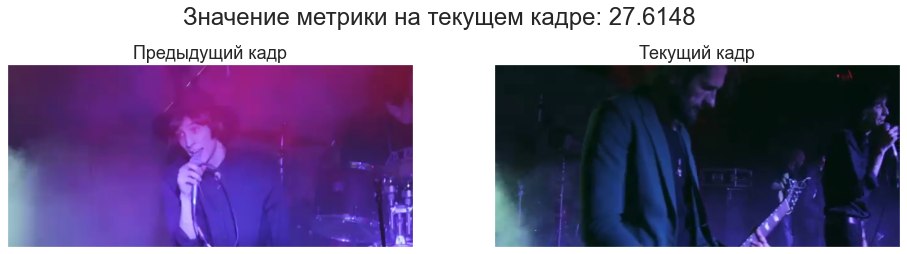

In [14]:
##### Посмотрим на найденные смены сцен
idx = 52
visualize_metric_error(vis[idx][0], vis[idx][1], metric_values[scene_changes_base[idx]])

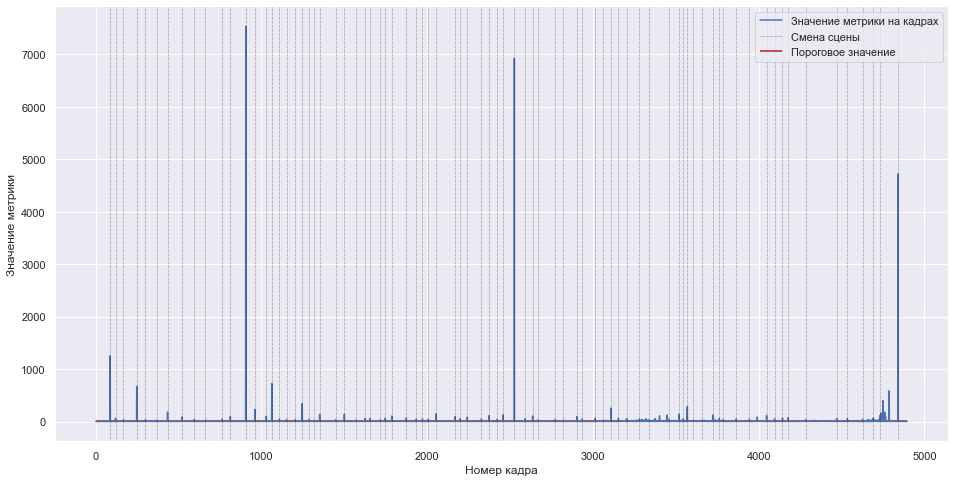

In [15]:
#### Посмотрим на значения метрики
visualize_metric_values(metric_values, 6 , cuts)

### Подсчёт метрики F1-Score

Чтобы оценивать алгоритм и научиться сравнивать несколько алгоритмов, нужна метрика качества. В данной задаче для оценки качества алгоритма используется F1-Score. Преимущества использования этой метрики к текущей постановке задачи смены сцен были рассказаны на лекции, напишем только формулы:
$$precision = \frac{tp}{tp+fp}$$
$$recall = \frac{tp}{tp+fn}$$
$$F = 2 * \frac{precision * recall}{precision+recall}$$

На всякий случай опишем как именно происходит подсчёт метрики для видео

1) Сначала из выборки удаляются все кадры, которые по разметке либо являются сложными переходами между сценами, либо помечены как сложные для анализа и разметки (например, титры/обилие компьютерной графики и т.п)


2) Затем для оставшихся кадров уже подсчитывается F1_Score

In [49]:
def calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = 0, 0, 0, 0
    scene_len = scene_len
    for scd in predicted_scd:
        if scd in true_scd:
            tp += 1
        elif scd not in not_to_use_frames:
            fp += 1
    for scd in true_scd:
        if scd not in predicted_scd:
            fn += 1
    tn = scene_len - len(not_to_use_frames) - tp - fp - fn
    return tp, fp, tn, fn

In [50]:
def calculate_precision(tp, fp, tn, fn):
    return tp / max(1, (tp + fp))

In [51]:
def calculate_recall(tp, fp, tn, fn):
    return tp / max(1, (tp + fn))

In [52]:
def f1_score(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames)
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [53]:
def f1_score_matrix(tp, fp, tn, fn):
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

### Тестируем разработанный метод сразу на нескольких видео 

In [54]:
def run_scene_change_detector_all_video(scene_change_detector, dataset_path):
    video_dataset = load_json_from_file(os.path.join(dataset_path, 'info.json'))
    param_log = {
        '_mean_f1_score': []
    }
    for video_info in tqdm(video_dataset, leave=False):
        # Загружаем видео, его длину и смены сцен
        frames = read_video(os.path.join(dataset_path, video_info['source']))
        video_len = video_info['len']
        true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))
        
        # Составляем список сцен, которые не будут тестироваться
        not_use_frames = set()
        for type_scene_change in ['trash', 'fade', 'dissolve']:
            for bad_scene_range in true_scene_changes.get(type_scene_change, []):
                not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))
        
        predicted_scene_changes, _, _ = scene_change_detector(frames)
        
        param_log['f1_score_{}'.format(video_info['source'])] = f1_score(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )
        video_tp, video_fp, video_tn, video_fn = calculate_matrix(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )
        
        param_log['tp_{}'.format(video_info['source'])] = video_tp
        param_log['fp_{}'.format(video_info['source'])] = video_fp
        param_log['tn_{}'.format(video_info['source'])] = video_tn
        param_log['fn_{}'.format(video_info['source'])] = video_fn 
        param_log['_mean_f1_score'].append(param_log['f1_score_{}'.format(video_info['source'])])
    param_log['_mean_f1_score'] = np.mean(param_log['_mean_f1_score'])
    return param_log

In [22]:
video_dataset = 'train_dataset'

In [267]:
#Протестируем базовый метод
run_scene_change_detector_all_video(baseline_scene_change_detector, video_dataset)

{'_mean_f1_score': 0.5219806811946295,
 'f1_score_video/03.mp4': 0.08812260536398467,
 'tp_video/03.mp4': 23,
 'fp_video/03.mp4': 476,
 'tn_video/03.mp4': 2696,
 'fn_video/03.mp4': 0,
 'f1_score_video/04.mp4': 0.8387096774193549,
 'tp_video/04.mp4': 26,
 'fp_video/04.mp4': 6,
 'tn_video/04.mp4': 3352,
 'fn_video/04.mp4': 4,
 'f1_score_video/05.mp4': 0.9,
 'tp_video/05.mp4': 18,
 'fp_video/05.mp4': 4,
 'tn_video/05.mp4': 5252,
 'fn_video/05.mp4': 0,
 'f1_score_video/07.mp4': 0.8173913043478261,
 'tp_video/07.mp4': 94,
 'fp_video/07.mp4': 34,
 'tn_video/07.mp4': 3185,
 'fn_video/07.mp4': 8,
 'f1_score_video/08.mp4': 0.08333333333333333,
 'tp_video/08.mp4': 1,
 'fp_video/08.mp4': 0,
 'tn_video/08.mp4': 2587,
 'fn_video/08.mp4': 22,
 'f1_score_video/10.mp4': 0.4705882352941176,
 'tp_video/10.mp4': 20,
 'fp_video/10.mp4': 23,
 'tn_video/10.mp4': 2675,
 'fn_video/10.mp4': 22,
 'f1_score_video/14.mp4': 0.43956043956043955,
 'tp_video/14.mp4': 40,
 'fp_video/14.mp4': 102,
 'tn_video/14.mp4': 1

In [130]:
#Протестируем разработанный вами метод
run_scene_change_detector_all_video(scene_change_detector, video_dataset)

{'_mean_f1_score': 0.919592558741612,
 'f1_score_video/03.mp4': 0.9787234042553191,
 'tp_video/03.mp4': 23,
 'fp_video/03.mp4': 1,
 'tn_video/03.mp4': 3171,
 'fn_video/03.mp4': 0,
 'f1_score_video/04.mp4': 0.967741935483871,
 'tp_video/04.mp4': 30,
 'fp_video/04.mp4': 2,
 'tn_video/04.mp4': 3356,
 'fn_video/04.mp4': 0,
 'f1_score_video/05.mp4': 0.972972972972973,
 'tp_video/05.mp4': 18,
 'fp_video/05.mp4': 1,
 'tn_video/05.mp4': 5255,
 'fn_video/05.mp4': 0,
 'f1_score_video/07.mp4': 0.9665071770334929,
 'tp_video/07.mp4': 101,
 'fp_video/07.mp4': 6,
 'tn_video/07.mp4': 3213,
 'fn_video/07.mp4': 1,
 'f1_score_video/08.mp4': 0.9777777777777777,
 'tp_video/08.mp4': 22,
 'fp_video/08.mp4': 0,
 'tn_video/08.mp4': 2587,
 'fn_video/08.mp4': 1,
 'f1_score_video/10.mp4': 0.8571428571428571,
 'tp_video/10.mp4': 42,
 'fp_video/10.mp4': 14,
 'tn_video/10.mp4': 2684,
 'fn_video/10.mp4': 0,
 'f1_score_video/14.mp4': 0.9195402298850576,
 'tp_video/14.mp4': 40,
 'fp_video/14.mp4': 7,
 'tn_video/14.mp4

## Подключаем Машинное обучение

### Модель чисто демонстративная,  и ее результат хуже эвристики

In [23]:
from sklearn.model_selection import cross_val_score
import pandas as pd
import pickle
from skimage.color import rgb2gray
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [46]:
def scene_change_detector_reconst(frames, threshold = 6, with_vis=False):
    scene_changes = []
    vis = []
    metric_values = []


    def abs_metric_bins_v1(frame_1, frame_2, channels, colors):
        ar = np.abs(cv2.calcHist([frame_1],[channels],None,[colors],[0,256]) - cv2.calcHist([frame_2],[channels],None,[colors],[0,256]))

        return ar.reshape(colors)

    def chi_square_metric_bins_v1(frame_1, frame_2, channels, colors):
        temp = cv2.calcHist([frame_2],[channels],None,[colors],[0,256])
        temp[temp == 0] = 1
        ar = np.square(cv2.calcHist([frame_1],[channels],None,[colors],[0,256]) - temp)/temp
        return ar.reshape(colors)

    def abs_metric_bins_v2(frame_1, frame_2, channels, colors):
        hist_1 = cv2.calcHist([frame_1],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2 = cv2.calcHist([frame_2],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2[hist_2 == 0] = 1
        ar = np.abs(hist_1 - hist_2)

        return ar.reshape(colors)

    def chi_square_metric_bins_v2(frame_1, frame_2):
        hist_1 = cv2.calcHist([frame_1],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2 = cv2.calcHist([frame_2],[0,1,2],None,[4,4,4],[0,256,0,256,0,256])
        hist_2[hist_2 == 0] = 1
        ar = np.square(hist_1 - hist_2) / hist_2
        return np.sum(ar) / 64

    def chi_square_metric_subregions_v1(frame_1, frame_2):
        shape_row = frame_1.shape[0] // 4
        shape_col = frame_1.shape[1] // 4
        sum_global = np.array([])
        for i in np.arange(4):
            for j in np.arange(4):
                ar = 0
                for channel in [0,1,2]:
                    region_1 = frame_1[i * shape_row : (i + 1) * shape_row, j * shape_col : (j + 1) * shape_col]

                    region_2 = frame_2[i * shape_row : (i + 1) * shape_row, j * shape_col : (j + 1) * shape_col]
                    ar += np.sum(chi_square_metric_bins_v1(region_1, region_2, channel, 64)) / 64
                sum_temp = ar / 3

                sum_global = np.append(sum_global, sum_temp)
        sum_global = np.sort(sum_global)[0:8]

        return 1000 * np.sum(sum_global) / (shape_row * shape_col )
    
    def abs_metric_bins_subregions_v1(frame_1, frame_2):
        shape_row = frame_1.shape[0] // 4
        shape_col = frame_1.shape[1] // 4
        sum_global = np.array([])
        for i in np.arange(4):
            for j in np.arange(4):
                ar = 0
                for channel in [0,1,2]:
                    region_1 = frame_1[i * shape_row : (i + 1) * shape_row, j * shape_col : (j + 1) * shape_col]

                    region_2 = frame_2[i * shape_row : (i + 1) * shape_row, j * shape_col : (j + 1) * shape_col]
                    ar += np.sum(abs_metric_bins_v1(region_1, region_2, channel, 64)) / 64
                sum_temp = ar / 3

                sum_global = np.append(sum_global, sum_temp)
        sum_global = np.sort(sum_global)[0:8]

        return 1000 * np.sum(sum_global) / (shape_row * shape_col )
    
    
    def pixel_metric(frame, prev_frame):


        return np.mean((frame.astype(np.int32) - prev_frame) ** 2)

    def sobel(frame):
        ddept = cv2.CV_64F
        x = cv2.Sobel(frame, ddept, 1,0, ksize=3, scale=1)
        y = cv2.Sobel(frame, ddept, 0,1, ksize=3, scale=1)
        absx= cv2.convertScaleAbs(x)
        absy = cv2.convertScaleAbs(y)
        edge = cv2.addWeighted(absx, 0.5, absy, 0.5,0)
        return edge


    scene_changes = []
    vis = []
    metric_values_1 = []
    metric_values_2 = []
    metric_values_3 = []
    metric_values_4 = []
    metric_values_5 = []
    metric_values_6 = []
    metric_values_7 = [] 
    metric_values_8 = []
    prev_frame = None


    for idx, frame in notebook.tqdm(enumerate(frames), leave=False):
        sobel_f = sobel(frame)
        if prev_frame is not None:

            temp_array = np.zeros(256)
            temp_value = 0
            metric_value_1 = chi_square_metric_subregions_v1(sobel_f, sobel_pf)
            
            s_t = 0
            for ch in [0, 1, 2]:
                s_t += np.sum(abs_metric_bins_v1(sobel_f, sobel_pf, ch, 64))
            s_t /= 3
            metric_value_2 = s_t
            
            
            gray_frame = np.rint(rgb2gray(frame) * 255).astype('uint8')
            gray_prev_frame = np.rint(rgb2gray(prev_frame) * 255).astype('uint8')
            metric_value_3 = pixel_metric(gray_frame, gray_prev_frame)
            
            metric_value_4 = 0
            if len(metric_values_1) > 1:
                metric_value_4 = metric_value_1 - max(metric_values_1[-1],metric_values_1[-2])
               
            std = np.std(gray_frame)
            std_prev = np.std(gray_prev_frame)
            mean = np.mean(gray_frame)
            mean_prev = np.mean(gray_prev_frame)
            
            metric_value_5 = 0
            if (std*std_prev == 0): 
                metric_value_5 = np.square((std_prev + std) / 2 + np.square((mean_prev - mean) / 2))
            else:
                metric_value_5 = np.square((std_prev + std) / 2 + np.square((mean_prev - mean) / 2)) / std*std_prev
            
            metric_value_6 = mean
            metric_value_7 = std
            
            metric_value_8 = len(sobel_f[sobel_f == np.max(sobel_f)]) - len(sobel_pf[sobel_pf == np.max(sobel_pf)])
            
            metric_values_1.append(metric_value_1)
            metric_values_2.append(metric_value_2)
            metric_values_3.append(metric_value_3)
            metric_values_4.append(metric_value_4)
            metric_values_5.append(metric_value_5)
            metric_values_6.append(metric_value_6)
            metric_values_7.append(metric_value_7)
            metric_values_8.append(metric_value_8)
        else:
            gray_frame = np.rint(rgb2gray(frame) * 255).astype('uint8')  
            std = np.std(gray_frame)
            mean = np.mean(gray_frame)
            metric_value_6 = mean
            metric_value_7 = std

            metric_values_1.append(0)
            metric_values_2.append(0)
            metric_values_3.append(0)
            metric_values_4.append(0)
            metric_values_5.append(0)
            metric_values_6.append(metric_value_6)
            metric_values_7.append(metric_value_7)
            metric_values_8.append(0)
            
        prev_frame = frame
        sobel_pf = sobel_f

    
    return scene_changes, vis, metric_values_1, metric_values_2, metric_values_3, metric_values_4, metric_values_5, metric_values_6, metric_values_7, metric_values_8
    

In [25]:
def get_train_data(train_videos):
    
    X_train, y_train = np.array([]), np.array([])
    k = 0
    for video in train_videos:
        frames = read_video(os.path.join('train_dataset', 'video', f'{video}.mp4'))

        _, _, metric_values_1, metric_values_2, metric_values_3, metric_values_4, metric_values_5, metric_values_6, metric_values_7, metric_values_8 = scene_change_detector_reconst(frames) 
        
        cuts = load_json_from_file(os.path.join('train_dataset', 'gt', f'{video}.json'))['cut']
        video_scenes = np.array([0 for i in range(len(metric_values_1))])
        print(cuts)
        video_scenes[cuts] += 1
        if (k == 0):
        
            X_train = np.hstack((X_train, metric_values_1))
            X_train = np.vstack((X_train, metric_values_2))
            X_train = np.vstack((X_train, metric_values_3))
            X_train = np.vstack((X_train, metric_values_4))
            X_train = np.vstack((X_train, metric_values_5))
            X_train = np.vstack((X_train, metric_values_6))
            X_train = np.vstack((X_train, metric_values_7))
            X_train = np.vstack((X_train, metric_values_8))
            y_train = np.hstack((y_train, video_scenes))
        else:
            X_trai = np.array([])
            X_trai = np.hstack((X_trai, metric_values_1))
            X_trai = np.vstack((X_trai, metric_values_2))
            X_trai = np.vstack((X_trai, metric_values_3))
            X_trai = np.vstack((X_trai, metric_values_4))
            X_trai = np.vstack((X_trai, metric_values_5))
            X_trai = np.vstack((X_trai, metric_values_6))
            X_trai = np.vstack((X_trai, metric_values_7))
            X_trai = np.vstack((X_trai, metric_values_8))
            y_train = np.hstack((y_train, video_scenes))
            X_train = np.concatenate((X_train,X_trai),axis=1)    
        k += 1
    return X_train, y_train 

In [26]:
train_videos = ['04','05','21']

X_train, y_train = get_train_data(train_videos)

[80, 137, 236, 323, 472, 538, 677, 745, 885, 1080, 1187, 1281, 1399, 1458, 1543, 1650, 1709, 1757, 1808, 1863, 1960, 2227, 2593, 2658, 2757, 2812, 2884, 2982, 3076, 3181]


[5, 1028, 1211, 1520, 1713, 1788, 1862, 1890, 2171, 2492, 2551, 2708, 2750, 3028, 3466, 3712, 3934, 4457]


[87, 119, 167, 247, 300, 367, 433, 521, 594, 662, 763, 812, 905, 960, 1029, 1062, 1108, 1151, 1204, 1246, 1287, 1315, 1351, 1447, 1500, 1569, 1624, 1654, 1718, 1747, 1786, 1874, 1934, 1971, 2005, 2053, 2169, 2197, 2242, 2327, 2374, 2421, 2457, 2525, 2590, 2636, 2668, 2773, 2822, 2903, 2933, 3014, 3059, 3109, 3154, 3203, 3281, 3336, 3458, 3520, 3543, 3570, 3607, 3661, 3723, 3763, 3784, 3865, 3944, 4048, 4096, 4144, 4179, 4284, 4471, 4536, 4627, 4692, 4732, 4842]


In [47]:
# создание модели
model = xgb.XGBClassifier(
    learning_rate =0.25,
    n_estimators=5500,
    max_depth=1,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,

    nthread=4,
    scale_pos_weight=1,
    reg_alpha = 15,
    reg_lambda = 3,
    seed=27)
model.fit(X_train.T, y_train)
"""""""""
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap = True,
 max_depth = 16,
max_features = 'auto',
min_samples_leaf = 4,
 min_samples_split = 10,
 n_estimators = 1000)
model.fit(X_train.T, y_train)
"""""""""
None

In [48]:
pickle.dump(model, open("model.pkl", "wb"))

In [33]:
def run_scene_change_detector_ml_one_video(scene_change_detector, dataset_path, video_num):
    video_info = load_json_from_file(os.path.join(dataset_path, 'info.json'))[video_num]
    
    # Загружаем видео, его длину и смены сцен
    frames = read_video(os.path.join(dataset_path, video_info['source']))
    video_len = video_info['len']
    true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))

    # Составляем список сцен, которые не будут тестироваться
    not_use_frames = set()
    for type_scene_change in ['trash', 'fade', 'dissolve']:
        for bad_scene_range in true_scene_changes.get(type_scene_change, []):
            not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))

    predicted_scene_changes = scene_change_detector(frames)
   
    return  f1_score(
        true_scene_changes['cut'],
        predicted_scene_changes,
        video_len,
        not_use_frames
    )

In [55]:
run_scene_change_detector_ml_one_video(scene_change_detector_ml,'train_dataset',8)

0.8087431693989071

In [388]:
scores = cross_val_score(model, X_train.T, y_train, cv=5)
scores

array([0.99713364, 0.99390899, 0.99677419, 0.99820789, 0.97204301])

In [56]:
# GRADED
def scene_change_detector_ml(frames, with_vis = False):
    

    scene_changes = []
    vis = []
    _, _, metric_values_1, metric_values_2, metric_values_3, metric_values_4, metric_values_5, metric_values_6, metric_values_7, metric_values_8 = scene_change_detector_reconst(frames) 
    
    X_test = np.array([])
    X_test = np.hstack((X_test, metric_values_1))
    X_test = np.vstack((X_test, metric_values_2))
    X_test = np.vstack((X_test, metric_values_3))
    X_test = np.vstack((X_test, metric_values_4))
    X_test = np.vstack((X_test, metric_values_5))
    X_test = np.vstack((X_test, metric_values_6))
    X_test = np.vstack((X_test, metric_values_7))
    X_test = np.vstack((X_test, metric_values_8))

    X_test = X_test.T
    
    model = pickle.load(open("model.pkl", 'rb')) 
    predict_cuts = np.array(model.predict(X_test))
    return np.where(predict_cuts > 0)[0], vis, metric_values_1

In [57]:
video_dataset_path = 'train_dataset'

In [59]:
run_scene_change_detector_all_video(scene_change_detector_ml, video_dataset_path)

{'_mean_f1_score': 0.8640328252319176,
 'f1_score_video/03.mp4': 1.0,
 'tp_video/03.mp4': 23,
 'fp_video/03.mp4': 0,
 'tn_video/03.mp4': 3172,
 'fn_video/03.mp4': 0,
 'f1_score_video/04.mp4': 0.8727272727272728,
 'tp_video/04.mp4': 24,
 'fp_video/04.mp4': 1,
 'tn_video/04.mp4': 3357,
 'fn_video/04.mp4': 6,
 'f1_score_video/05.mp4': 0.8823529411764706,
 'tp_video/05.mp4': 15,
 'fp_video/05.mp4': 1,
 'tn_video/05.mp4': 5255,
 'fn_video/05.mp4': 3,
 'f1_score_video/07.mp4': 0.9238578680203046,
 'tp_video/07.mp4': 91,
 'fp_video/07.mp4': 4,
 'tn_video/07.mp4': 3215,
 'fn_video/07.mp4': 11,
 'f1_score_video/08.mp4': 0.6857142857142856,
 'tp_video/08.mp4': 12,
 'fp_video/08.mp4': 0,
 'tn_video/08.mp4': 2587,
 'fn_video/08.mp4': 11,
 'f1_score_video/10.mp4': 0.7999999999999999,
 'tp_video/10.mp4': 36,
 'fp_video/10.mp4': 12,
 'tn_video/10.mp4': 2686,
 'fn_video/10.mp4': 6,
 'f1_score_video/14.mp4': 0.8641975308641976,
 'tp_video/14.mp4': 35,
 'fp_video/14.mp4': 6,
 'tn_video/14.mp4': 1895,
 '